In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple

from robustness import logger
logger.setLevel('INFO')

from robustness import NETWORKS_DIR
from robustness.mpl_settings_v3 import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import (
    getLinearReg, 
    get_base_network_name, 
    powerlaw, 
    load_delta_data, 
    read_data_file
)
from robustness.plot_auxiliary import (
    letters,
    attack_dict,
    fig_dir, 
    load_delta,
    load_deltas,
    load_dataframe, 
    get_critical_measures,
    getPeaks,
    compute_fc_v2,
    get_rc_values,
    get_l_cutoff
)

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

marker_dict = {'meanS': 'o', 'Nsec': 's', 'varSgcc': '^', 'Sgcc': '*'}
color_dict = {'meanS': 'C0', 'Nsec': 'C1', 'varSgcc': 'C2', 'Sgcc': 'C3'}
linestyle_dict = {'meanS': '--', 'Nsec': '-.', 'varSgcc': ':', 'Sgcc': ':'}
measures_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 N$', 'varSgcc': r'$\chi$', 'Sgcc': r'$N_1$'}
line_colors = {'meanS': 'k', 'Nsec': 'grey', 'varSgcc': 'brown', 'Sgcc': 'C8'}

In [89]:
measures = ['meanS', 'Nsec']
attacks = [
    'Ran', 
    #'Deg', 'Btw_cutoff2', 
    #'Btw_cutoff3', 'Btw_cutoff4', 
    #'Btw_cutoff5', 'Btw_cutoff6', 'Btw_cutoff7', 
    #'Btw_cutoff8', 'Btw_cutoff16', 
    #'Btw_cutoff30',
    #'Btw_cutoff40', 'Btw_cutoff50', 'Btw_cutoff60', 'Btw_cutoff70'
]

sizes = [
    #1024,
    4096, 8192, 16384, 32768, 65536, 
    #131072, 262144
]

data = {}
for k, attack in enumerate(attacks):
    #print(attack)
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, nseeds=10000)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)

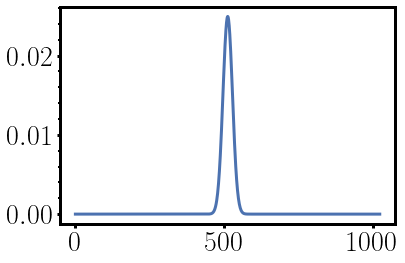

In [90]:
def binomial(N, p):
    n_max = int(p*N)
    arr = np.ones(N)
    for n in range(n_max+1, N):
        arr[n] = arr[n-1] * (N-n+1)/n * p/(1-p)
    for n in range(n_max-1, -1, -1):
        arr[n] = arr[n+1] * (n+1)/(N-n) * (1-p)/p  
    return arr / arr.sum()

def convolute(Qn_values, p_values=np.array([])):
    N = len(Qn_values)
    
    if len(p_values) == 0:
        p_values = np.arange(N) / N
    
    Qp_values = np.zeros_like(p_values)
    for i, p in enumerate(p_values):
        binom = binomial(N, p)
        Qp_values[i] = sum(
            binom[n] * Qn_values[n] 
            for n in range(N)
        )
    return Qp_values

N = 1024
p = 0.5

X = np.arange(N)
Y = binomial(N, p)
plt.plot(X, Y)

In [145]:
from collections import namedtuple, defaultdict

Window = namedtuple('Window', ['fmin', 'fmax'])
windows = {
    4096: Window(0.48, 0.52),
    8192: Window(0.49, 0.52),
    16384: Window(0.495, 0.52),
    32768: Window(0.495, 0.515),
    65536: Window(0.5, 0.51),
}

In [147]:
convoluted = defaultdict(dict)
measure = 'varSgcc'
for N, (fmin, fmax) in windows.items():
    df = dfs[N]
    f_values = np.arange(fmin, fmax, 1/N)
    Qn_values = df[measure].values
    Qp_values = convolute(Qn_values, p_values=f_values)
    convoluted[measure][N] = Qp_values

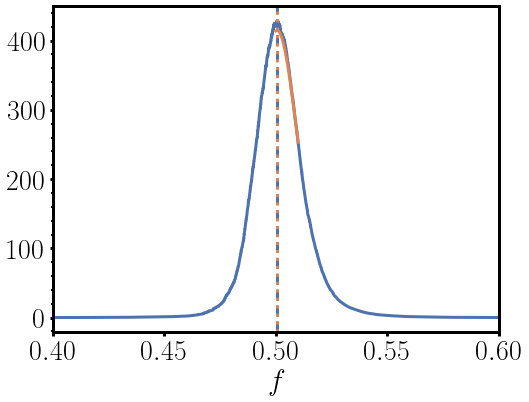

In [148]:
df = dfs[N]

ncols = nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
ax.set_xlabel(r'$f$')
ax.set_xlim(0.40, 0.60)
ax.plot(df.f, Qn_values, color='C0')
ax.axvline(Qn_values.argmax()/N, color='C0', linestyle='--')
ax.plot(f_values, Qp_values, color='C1')
ax.axvline(fmin + Qp_values.argmax()/N, color='C1', linestyle=':')
plt.show()

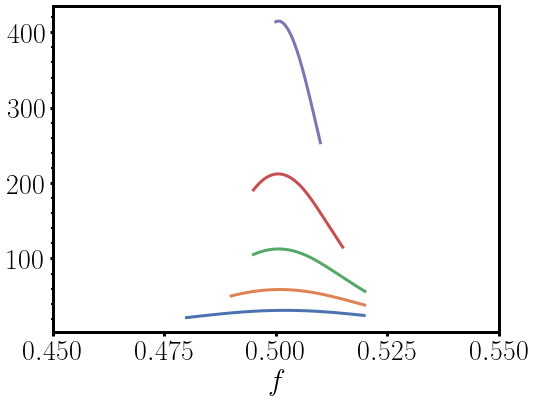

In [149]:
ncols = nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
ax.set_xlabel(r'$f$')
ax.set_xlim(0.45, 0.55)
for N, (fmin, fmax) in windows.items():   
    f_values = f_values = np.arange(fmin, fmax, 1/N)
    Qp_values = convoluted[measure][N]
    ax.plot(f_values, Qp_values)
    #ax.axvline(fmin + Qp_values.argmax()/N, linestyle=':')
plt.show()

0.06563399463013167


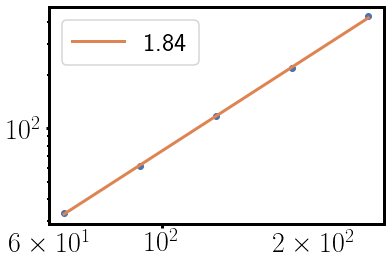

In [152]:
sizes = list(windows.keys())
#measure='varSgcc'
X = np.sqrt(sizes)
peak_values = [dfs[N][measure].max() for N in sizes]
#peak_values = [convoluted[measure][N].max() for N in sizes]
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
Y_pred, slope, err = getLinearReg(X, peak_values)
print(err)
label = round(slope, 3)
ax.plot(X, peak_values, 'o')
ax.plot(X, Y_pred, label=label)
ax.legend()
plt.show()

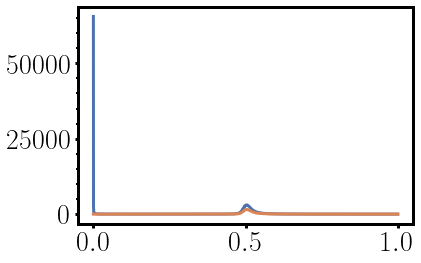

In [134]:
plt.plot(df.f.values[1:], df.meanS.values[1:]/df.f.values[1:])
plt.plot(df.f, df.meanS)